### Pedalcast: Predicting daily bike usage for each station - Modeling & Feature Engineering Notebook

#### Imports

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import joblib
import holidays

from collections import defaultdict
from itertools import groupby
from operator import itemgetter


In [81]:
daily_counts = pd.read_csv('data/daily_counts_with_weather.csv')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

### Feature Engineering: `create_features(df)`

This function generates key features to support station-level bike demand forecasting. It takes a DataFrame with daily trip counts and returns a new DataFrame with additional time-based and lag features, including:

- **Calendar Features**:  
  `dayofweek`, `is_weekend`, `month`, `quarter`, `year`, `dayofyear`, `dayofmonth`, and `weekofyear`  
  These capture patterns related to the day, seasonality, and temporal cycles.

- **Season Label**:  
  A simplified `season` column is derived from the month and one-hot encoded.
- **Holiday Indicator**:

	`is_holiday`: Boolean indicating whether the date is a U.S. federal holiday, based on the holidays package.
- **Lag Features** (per station):  
  - `lag_1`: Trip count from the previous day  
  - `lag_7`: Trip count from the same day the previous week  
  - `rolling_7`: 7-day rolling average of trip count (excluding the current day)  

These features allow the model to learn from both recent usage trends and structured temporal patterns.

In [82]:
def create_features(df):
    out = df.copy()
    # Monday(0) - Sunday (6)
    out['dayofweek'] = out['date'].dt.dayofweek
    out['is_weekend'] = out['dayofweek'] >= 5
    out['quarter'] = out['date'].dt.quarter 
    out['year'] = out['date'].dt.year 
    out['month'] = out['date'].dt.month 
    out['dayofyear'] = out['date'].dt.dayofyear 
    out['dayofmonth'] = out['date'].dt.day 
    out['weekofyear'] = out['date'].dt.isocalendar().week 
   
    def assign_season(month):
        if month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return 'Winter'

    out['season'] = out['month'].apply(assign_season)
    
    out = out.sort_values(['start_station_id', 'date'])

    out['lag_1'] = out.groupby('start_station_id')['trip_count'].shift(1)

    out['lag_7'] = out.groupby('start_station_id')['trip_count'].shift(7)
    
    out['rolling_7'] = (
        out.groupby('start_station_id')['trip_count']
           .shift(1)  # Exclude today
           .rolling(window=7)
           .mean()
           .reset_index(level=0, drop=True)
    )
    
    us_holidays = holidays.UnitedStates()

    out['is_holiday'] = out['date'].isin(us_holidays)
    
    return out

In [83]:
daily_counts_wft = create_features(daily_counts)
daily_counts_wft.head()

,start_station_id,start_station_name,date,trip_count,temp,humidity,precip,snow,windspeed,visibility,...,year,month,dayofyear,dayofmonth,weekofyear,season,lag_1,lag_7,rolling_7,is_holiday
0,A32000,Fan Pier,2023-07-01,30,19.3,93.5,0.000,0.0,20.3,4.8,...,2023,7,182,1,26,Summer,NaN,NaN,NaN,False
1,A32000,Fan Pier,2023-07-02,20,20.9,89.9,8.278,0.0,28.9,7.6,...,2023,7,183,2,26,Summer,30.0,NaN,NaN,False
2,A32000,Fan Pier,2023-07-03,28,20.4,89.4,14.249,0.0,18.0,10.4,...,2023,7,184,3,27,Summer,20.0,NaN,NaN,False
3,A32000,Fan Pier,2023-07-04,35,20.1,94.4,12.163,0.0,16.4,12.0,...,2023,7,185,4,27,Summer,28.0,NaN,NaN,False
4,A32000,Fan Pier,2023-07-05,41,23.9,78.4,0.000,0.0,17.8,13.3,...,2023,7,186,5,27,Summer,35.0,NaN,NaN,False


### Drop Rows with Missing Lag Features

Lag features like `lag_1`, `lag_7`, and `rolling_7` require prior data to be computed. As a result, the earliest days for each station (where lag values are undefined) contain missing values.
So, we drop them to ensure all training data has complete feature sets, which also preserves model quality by removing rows that lack historical context.

In [84]:
# drop some rows for lags
daily_counts_wft.isna().sum()[daily_counts_wft.isna().sum()!=0]

lag_1         572
lag_7        3988
rolling_7    3988
dtype: int64

In [85]:
# drop values with missing lags
daily_counts_wft = daily_counts_wft.dropna(subset=['lag_1', 'lag_7', 'rolling_7'])

#### Train/Test Split for Forecasting

We separate the dataset into features (`X`) and target (`y`), where `trip_count` is the value we want to predict.

Then, we split the data into:

- **Training data** includes all dates **before June 2025**
- **Test data** includes dates in **June 2025**, which we will use to evaluate model performance on unseen future data

Later, we’ll use TimeSeriesSplit for cross-validation on the training data during hyperparameter tuning, to ensure the model is validated on temporally consistent folds.

In [86]:
X = daily_counts_wft.drop(['trip_count'],axis=1,errors='ignore')
y = daily_counts_wft['trip_count']

X_train = X[X['date'] < '2025-06-01']
X_test = X[X['date'] >= '2025-06-01']
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

We drop columns `start_station_name` and `date` since they are non-numeric and redundant (already encoded). We needed them before to do certain operations like in the previous cell.

In [87]:
drop_cols = ['start_station_name', 'date']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

#### Modeling Pipeline with One-Hot Encoding and XGBoost

We define a scikit-learn `Pipeline` that performs both preprocessing and model training in a single, reusable workflow:

- **`ColumnTransformer` with `OneHotEncoder`**:
  - Applies one-hot encoding to the categorical columns `start_station_id` and `season`

- **`XGBRegressor`**:
  - A tree-based regression model from the XGBoost library
  - Trained on the encoded and passed-through features

In [88]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(
        handle_unknown='ignore', drop='first'), ['start_station_id','season'])
    ],
    remainder='passthrough'  
)

xgb_pipeline = Pipeline(steps=[
    ('encoder', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

#### Hyperparameter Tuning with GridSearchCV

We perform a grid search over a predefined set of XGBoost hyperparameters to find the combination that minimizes RMSE.

- **Parameters tuned**: `max_depth`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`
- **Cross-validation**: `TimeSeriesSplit` ensures temporally consistent folds
- **Scoring**: Negative RMSE is used as the optimization metric

The best model configuration is selected based on cross-validated RMSE.

**Note**: Other parameter combinations were also tested, but this setup consistently produced the best performance.

In [89]:
param_grid = {
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.05, 0.1],
    "model__n_estimators": [100, 300],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.8],
}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid,
    scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
    },  
    refit="rmse",# use RMSE
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best RMSE: {-xgb_grid_search.best_score_:.2f}")
print("Best params:", xgb_grid_search.best_params_)
# Get R² score for the best model
best_index = xgb_grid_search.best_index_
best_r2 = xgb_grid_search.cv_results_['mean_test_r2'][best_index]
print(f"R²: {best_r2:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.7s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.0s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   0.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   1.4s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.8s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   2.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   2.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   1.3s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   2.9s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   2.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   3.6s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   2.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   2.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   1.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   2.9s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   4.6s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   2.8s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   2.1s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   3.9s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   2.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.4s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   3.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   4.8s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   3.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   4.0s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   5.8s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.6s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   1.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   4.3s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   2.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   0.7s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   2.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   1.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   1.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   5.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   2.6s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   1.9s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   1.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   3.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   6.8s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   2.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   4.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   1.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   2.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   1.4s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   7.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   2.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   3.3s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   2.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   4.0s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   2.4s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   2.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   4.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   2.9s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   3.4s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   4.1s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.1, model__max_depth=7, model__n_estimators=300, model__subsample=0.8; total time=   4.2s
Best RMSE: 10.14
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 0.8}
R²: 0.8932


#### Final Model Evaluation on Test Set

We use the best model from `GridSearchCV` to predict bike demand on the June 2025 test set.

- **RMSE (Root Mean Squared Error)** measures the average prediction error in trip counts.
- **R² Score** indicates how much variance in the target is explained by the model.

These metrics give a final assessment of how well the model generalizes to unseen future data.

In [90]:
y_pred = xgb_grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Test RMSE: 9.27
R² Score: 0.9228


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros

/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [91]:
xgb_grid_search.best_params_

{'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.05,
 'model__max_depth': 7,
 'model__n_estimators': 300,
 'model__subsample': 0.8}

This indicates strong predictive performance. Additionally, comparing validation scores and testing scores, we see that the model did not overfit to our data.

#### Comparing Predicted and Actual Trip Counts

We compare the model's predicted trip counts with actual observed values to assess its accuracy:

- Aggregate trip counts per day across all stations to observe overall daily trends and visualize these trends in a line chart, showing how predicted demand aligns with actual usage over time.

- Additionally, we break down predictions and actuals by station to inspect performance at a more granular level, using color and line style to distinguish between stations and prediction types.

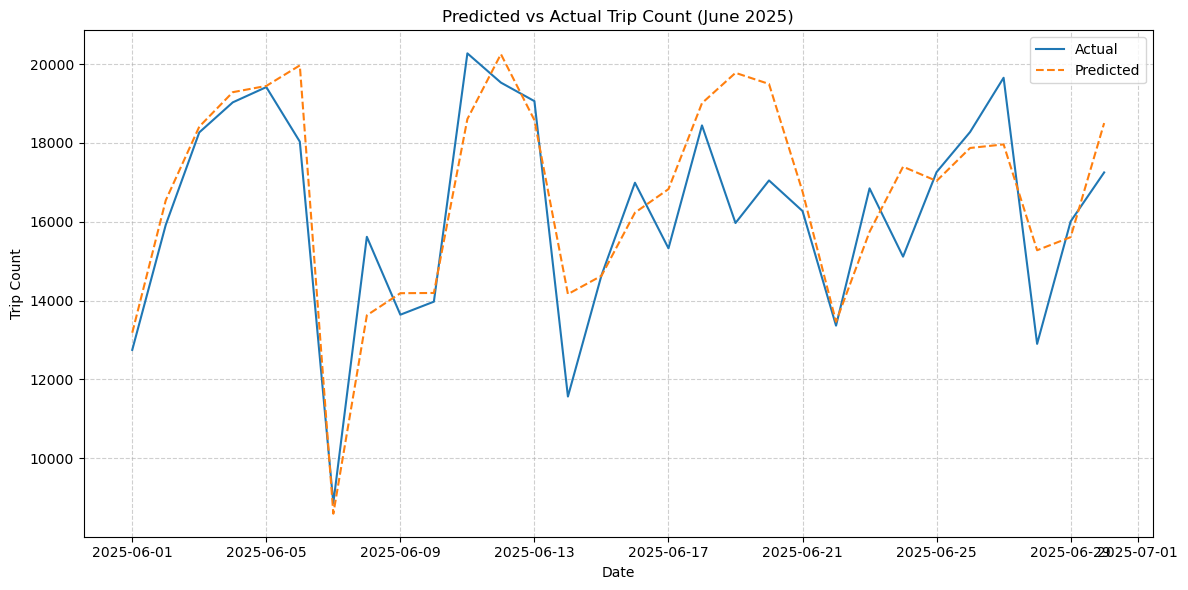

In [92]:
# Step 1: Add predictions and actuals
y_test_pred_df = X_test.copy()
y_test_pred_df['actual'] = y_test
y_test_pred_df['predicted'] = y_pred

# Step 2: Rebuild date from features
y_test_pred_df['date'] = pd.to_datetime({
    'year': y_test_pred_df['year'],
    'month': y_test_pred_df['month'],
    'day': y_test_pred_df['dayofmonth']
})

# Step 3: Aggregate trip counts per day
daily_actual_vs_pred = (
    y_test_pred_df
    .groupby('date')[['actual', 'predicted']]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))

plt.plot(daily_actual_vs_pred['date'], daily_actual_vs_pred['actual'], label='Actual', linestyle='-')
plt.plot(daily_actual_vs_pred['date'], daily_actual_vs_pred['predicted'], label='Predicted', linestyle='--')

plt.title("Predicted vs Actual Trip Count (June 2025)")
plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [93]:
def plot_actual_vs_predicted_by_station(y_test_pred_df, station_ids=None, top_n=10):
    # Step 1: Aggregate by date and station
    daily = (
        y_test_pred_df
        .groupby(['date', 'start_station_id'])[['actual', 'predicted']]
        .sum()
        .reset_index()
    )

    # Step 2: Select stations
    if station_ids is None:
        top_stations = (
            daily.groupby('start_station_id')['actual']
            .sum()
            .sort_values(ascending=False)
            .head(top_n)
            .index
        )
        filtered = daily[daily['start_station_id'].isin(top_stations)]
    else:
        filtered = daily[daily['start_station_id'].isin(station_ids)]

    # Step 3: Melt into long format
    melted = pd.melt(
        filtered,
        id_vars=["date", "start_station_id"],
        value_vars=["actual", "predicted"],
        var_name="type",
        value_name="trip_count"
    )

    # Step 4: Plot
    fig = px.line(
        melted,
        x="date",
        y="trip_count",
        color="start_station_id",
        line_dash="type",
        title="Predicted vs Actual Trip Count per Station",
        labels={"trip_count": "Trip Count", "start_station_id": "Station", "type": "Legend"},
        template="plotly_white"
    )
    fig.show()
plot_actual_vs_predicted_by_station(y_test_pred_df)

#### Most Important Features for the Model

**XGBoost’s Built-in Feature Importances**  
   - `feature_importances_` returns the relative importance of each feature based on how much it contributes to reducing error (gain) across all trees.
   - A horizontal bar plot visualizes which features the model relied on most globally.
   - Another bar plot is shown for features not including stations to see the other variables.

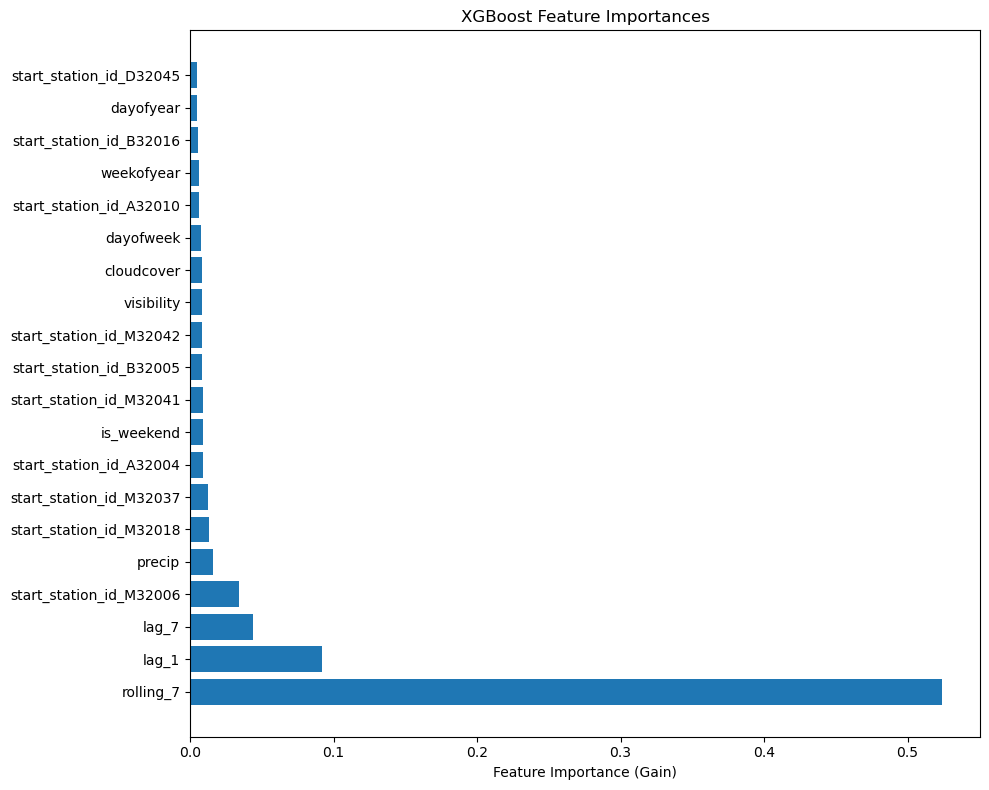

                     feature  importance
579                rolling_7    0.524294
577                    lag_1    0.091688
578                    lag_7    0.043509
357  start_station_id_M32006    0.034338
564                   precip    0.015722
366  start_station_id_M32018    0.013141
384  start_station_id_M32037    0.012107
3    start_station_id_A32004    0.009028
570               is_weekend    0.008838
388  start_station_id_M32041    0.008614
63   start_station_id_B32005    0.008459
389  start_station_id_M32042    0.008405
567               visibility    0.007996
568               cloudcover    0.007977
569                dayofweek    0.007703
8    start_station_id_A32010    0.006287
576               weekofyear    0.006176
72   start_station_id_B32016    0.005281
574                dayofyear    0.004995
261  start_station_id_D32045    0.004484


In [94]:
# Step 1: Get encoded feature names from OneHotEncoder
ohe = xgb_grid_search.best_estimator_.named_steps['encoder'].named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(['start_station_id', 'season'])

# Step 2: Combine encoded + passthrough column names
# These are columns not one-hot encoded
passthrough_cols = [col for col in X_train.columns if col not in ['start_station_id', 'season']]
feature_names = list(encoded_feature_names) + passthrough_cols

# Step 3: Get model importances (same length as feature_names)
model = xgb_grid_search.best_estimator_.named_steps['model']
importances = model.feature_importances_

# Step 4: Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Step 6: Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# Print top 20 features
print(importance_df.head(20))

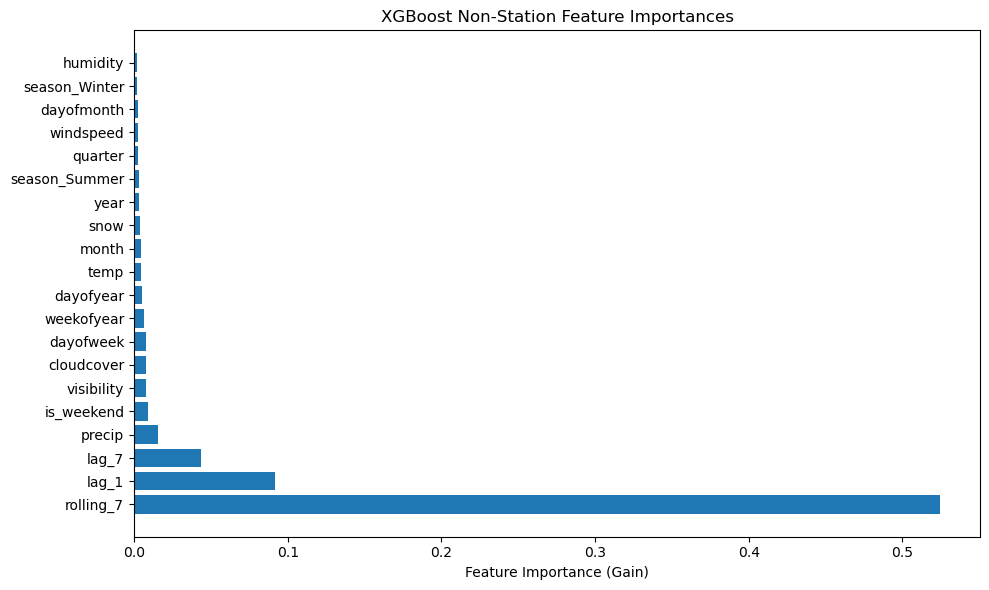

           feature  importance
579      rolling_7    0.524294
577          lag_1    0.091688
578          lag_7    0.043509
564         precip    0.015722
570     is_weekend    0.008838
567     visibility    0.007996
568     cloudcover    0.007977
569      dayofweek    0.007703
576     weekofyear    0.006176
574      dayofyear    0.004995
562           temp    0.004271
573          month    0.004208
565           snow    0.003678
572           year    0.003209
560  season_Summer    0.002876
571        quarter    0.002833
566      windspeed    0.002350
575     dayofmonth    0.002250
561  season_Winter    0.002043
563       humidity    0.002029


In [95]:
non_station_df = importance_df[~importance_df['feature'].str.startswith('start_station_id')]

# View top non-station features

plt.figure(figsize=(10, 6))
plt.barh(non_station_df['feature'][:20], non_station_df['importance'][:20])
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Non-Station Feature Importances")
plt.tight_layout()
plt.show()
print(non_station_df.head(20))

#### Interpretation of XGBoost Feature Importances

The model's internal feature importance ranking confirms that recent activity is the strongest predictor of daily bike demand:



- **`rolling_7`** (7-day rolling average) is by far the most important feature, contributing over 50% of the total gain (the average improvement in the model’s loss function when a feature is used to split a node). This suggests strong weekly patterns in usage.
- **`lag_1`** and **`lag_7`** also rank highly, capturing short- and long-term temporal dependencies.
- **Station-specific effects** are learned through one-hot encoding of `start_station_id` — several station IDs (e.g., `M32006`, `M32037`, `A32018`) appear among the top 20 features. This indicates that the model learns meaningful differences in demand behavior across locations, but without overfitting to them.
- **Weather features** like `precip`, `visibility`, and `cloudcover` contribute a bit but less than lag features.
- **Calendar features** (`dayofweek`, `is_weekend`) also contribute a bit, indicating that while time of week and seasonality affect demand, they’re secondary to usage history.


Overall, the model relies primarily on recent trip patterns, with station-specific effects, weather, and calendar signals providing useful context.

### Final Model Training on All Data

After evaluating the model's performance and interpreting feature importances, we retrain the final XGBoost pipeline on the entire dataset — including both the training and test sets.

This ensures that the model has access to the full set of historical patterns before being saved or deployed with the best hyperparameters from gridsearch.

In [96]:
# Remove "model__" prefix from best_params_
best_model_params = {
    key.replace("model__", ""): value
    for key, value in xgb_grid_search.best_params_.items()
}

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

final_pipeline = Pipeline(steps=[
    ('encoder', preprocessor),
    ('model', XGBRegressor(**best_model_params, random_state=42))
])

final_pipeline.fit(X_full, y_full)

/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['start_station_id',
                                                   'season'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              ena...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

### Saving and Loading the Final Model

After training, we save the entire modeling pipeline using `joblib`. This includes:
- Some of the preprocessing steps (`OneHotEncoder`)
- The trained `XGBRegressor` model

#### Loading the model later:

To reuse the model in a new notebook and predict:

```python
import joblib
loaded_model = joblib.load('xgb_final_model.pkl')
loaded_model.predict(X_new)

In [97]:
joblib.dump(final_pipeline, 'xgb_final_model.pkl')

['xgb_final_model.pkl']

#### Detecting Seasonal Inactivity

To avoid forecasting for stations during periods when they’ve never been active, we identify seasonal inactivity as follows:

1. Normalize across years: Add `dayofyear` and `year` to align activity by calendar day.
2. Build activity matrix: Mark each station-day as active if `trip_count > 0`.
3. Invert to inactivity: Identify days that were never active across any year.
4. Group into spans: Detect consecutive inactive days and retain blocks ≥ 45 days.
5. Store results: Save (start_day, end_day) tuples per station to filter future forecasts.

This avoids predictions during seasonal closures (e.g. winter) while still allowing forecasts for newer stations.

In [98]:
# 1. Create a 'day of year' column to normalize across years
daily_counts['dayofyear'] = daily_counts['date'].dt.dayofyear
daily_counts['year'] = daily_counts['date'].dt.year

# 2. Pivot: For each station and dayofyear, see if there was *any* activity
activity_matrix = (
    daily_counts.groupby(['start_station_id', 'year', 'dayofyear'])['trip_count']
    .sum()
    .reset_index()
)

# 3. Mark whether activity occurred (1) or not (0)
activity_matrix['active'] = activity_matrix['trip_count'] > 0

# 4. Aggregate across all available years: was a station ever active on this day?
ever_active = (
    activity_matrix
    .groupby(['start_station_id', 'dayofyear'])['active']
    .any()
    .unstack(fill_value=False)  # rows: stations, columns: 1–366
)

# 5. Find periods where the station was *never* active on any year
never_active = ~ever_active  # Flip to inactivity

# 6. Detect continuous inactivity spans (e.g., 11/14 to 3/14 ~ days 318–73)
seasonal_inactivity = defaultdict(list)

for station_id, inactive_days in never_active.iterrows():
    inactive_doys = inactive_days[inactive_days].index.tolist()

    if not inactive_doys:
        continue

    # Group consecutive dayofyear values

    for k, g in groupby(enumerate(inactive_doys), lambda x: x[1] - x[0]):
        block = list(map(itemgetter(1), g))
        if len(block) >= 45:  # Only consider "seasonal" if >45 days
            seasonal_inactivity[station_id].append((block[0], block[-1]))

# 7. Show some examples
for station, blocks in list(seasonal_inactivity.items())[:5]:
    print(f"{station}: inactive blocks → {blocks}")

A32014: inactive blocks → [(1, 155), (182, 366)]
A32021: inactive blocks → [(1, 118), (182, 366)]
A32024: inactive blocks → [(182, 275)]
A32029: inactive blocks → [(1, 72)]
A32034: inactive blocks → [(1, 127)]


#### Forecasting Future Bike Demand

To generate predictions for future dates, we define a `forecast_bike_demand()` function that simulates each day recursively.

- **Historical data** (including trip counts) is combined with a date-station grid for the prediction period.
- For each forecasted date, the function:
  1. Creates features including lag and rolling statistics using the latest available data
  2. Uses the trained XGRegressor model to predict demand for every station on that day
  3. Appends the predictions back into the dataset so they can be used as lags in the next day's forecast
- This recursive structure allows the model to forecast multiple consecutive days, even when no true data exists beyond the last historical date.
- The final result is a clean DataFrame of predicted trip counts per station for each day for the requested date range.

To support forecasting, we also provide the model with **future weather data** from **July 1, 2025 to July 1, 2027**, downloaded from the [Visual Crossing API](https://www.visualcrossing.com/). This ensures the model can incorporate temperature, precipitation, wind, and other conditions during prediction. You can also use it later to get more dates if needed.

##### Skipping Seasonally Inactive Stations

Some stations are consistently closed during specific parts of the year, such as winter. To avoid generating unrealistic predictions for these periods, we use an `is_inactive()` function:

- It checks whether a station is inactive on a given day-of-year based on historical patterns based on the `seasonal_inactivity` dict we defined in the cell before this.
- The forecast function skips predictions for (station, date) pairs where inactivity is detected.

#### Visualizing Predictions

We use the `plot_predictions()` function to create an interactive Plotly line chart of predicted demand over time, grouped by station.

- `top_n`(default = 10) Number of stations to show, based on total predicted trips during the forecast period. Only used if `station_ids` is not specified.
- `station_ids`(optional) A list of specific `start_station_id`s to visualize. If provided, this overrides `top_n`.

Below, we apply the forecasting function to predict demand from **July 1 to July 7, 2025** using the trained model and visualize the predictions.

In [99]:
# future weather forecast from July 1 2025 through July 1 2027
weather_future = pd.read_csv('data/weather_future.csv')[['datetime','temp','humidity','precip','snow','windspeed','visibility','cloudcover']]
weather_future['date'] = pd.to_datetime(pd.to_datetime(weather_future['datetime']).dt.date)
weather_future.tail()

,datetime,temp,humidity,precip,snow,windspeed,visibility,cloudcover,date
726,2027-06-27,22.5,68.6,3.1,NaN,25.9,12.5,46.2,2027-06-27
727,2027-06-28,22.5,71.3,4.2,NaN,25.6,13.4,64.6,2027-06-28
728,2027-06-29,22.5,71.3,3.1,NaN,21.6,13.9,58.0,2027-06-29
729,2027-06-30,23.1,65.1,1.3,NaN,23.8,14.3,52.9,2027-06-30
730,2027-07-01,22.9,68.5,4.4,NaN,25.2,13.6,53.2,2027-07-01


In [100]:
def forecast_bike_demand(start_date, end_date, full_data, model_pipeline, station_ids=None):
    """
    Forecasts bike demand per station from start_date to end_date using past data and a trained pipeline.
    """

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # 1. Filter to historical data needed for lags
    history_window = (full_data[['start_station_id','date','trip_count']].copy())
    
    # 2. Get list of all active stations to forecast if user doesn't choose specific stations
    if station_ids is None:
        # default to all stations in June 2025
        stations = (full_data[
            (full_data['date'] >= '2025-06-01') & (full_data['date'] <= '2025-06-30')]
            ['start_station_id'].unique())
    else:
        stations = station_ids
    
    recursive_start = pd.to_datetime("2025-07-01")

    # 3. Create empty grid of future dates × stations
    future_dates = pd.date_range(start=recursive_start, end=end_date, freq='D')
    future_df = pd.DataFrame([(station, date) for station in stations for date in future_dates],
                             columns=['start_station_id', 'date'])
    
    # 4. Combine with historical data (to allow lag feature generation)
    combined = pd.concat([history_window, future_df], ignore_index=True, sort=False)

    # 5. Create placeholder for predictions
    all_predictions = []

    # 6. Forecasting window
    forecast_dates = pd.date_range(
        start=recursive_start,
        end=end_date,
        freq='D'
    )

    # 7. Start with combined base data (historical + blank rows)
    combined = pd.concat([history_window, future_df], ignore_index=True, sort=False)
    combined = combined.merge(weather_future, on='date', how='left')

    for forecast_date in forecast_dates:
        # Create features with latest known + predicted values
        temp = create_features(combined.copy())

        # Filter to the row for this forecast date
        row = temp[temp['date'] == forecast_date]
        if seasonal_inactivity:
            row = row[~row.apply(
                lambda r: is_inactive(r['start_station_id'], r['date'], seasonal_inactivity),
                axis=1
            )]
        if row.empty:
            continue

        # Predict
        X_row = row.drop(columns=['trip_count'], errors='ignore')
        y_pred = model_pipeline.predict(X_row)

        row['trip_count'] = y_pred
        all_predictions.append(row[['date', 'start_station_id', 'trip_count']])

        # Append prediction back to combined to use in future lags
        combined = pd.concat([combined, row[['start_station_id', 'date', 'trip_count']]], ignore_index=True)

    # 8. Final result
    result_df = pd.concat(all_predictions, ignore_index=True)
    result_df.rename(columns={'trip_count': 'predicted_trip_count'}, inplace=True)
    result_df = result_df[(result_df['date'] >= start_date) & (result_df['date'] <= end_date)]

    return result_df[['date', 'start_station_id', 'predicted_trip_count']]

def is_inactive(station_id, date, inactivity_dict):
    doy = date.timetuple().tm_yday
    for start, end in inactivity_dict.get(station_id, []):
        if start <= doy <= end:
            return True
    return False

def plot_predictions(predictions_df, top_n=10,station_ids=None):
    if station_ids is not None:
        plot_df = predictions_df[predictions_df['start_station_id'].isin(station_ids)]
    else:
        top_stations = (
            predictions_df.groupby('start_station_id')['predicted_trip_count']
              .sum()
              .sort_values(ascending=False)
              .head(top_n)
              .index
        )
        plot_df = predictions_df[predictions_df['start_station_id'].isin(top_stations)]

    fig = px.line(
        plot_df,
        x="date",
        y="predicted_trip_count",
        color="start_station_id",
        title="Predicted Daily Bike Usage (Top Stations)",
        labels={"predicted_trip_count": "Predicted Trips"},
        template="plotly_white"
    )
    fig.show()

In [101]:
# Load saved model
loaded_model = joblib.load('xgb_final_model.pkl')

# Forecast demand for the first week of July 2025
predictions = forecast_bike_demand(
    start_date='2025-07-01',
    end_date='2025-07-07',
    full_data=daily_counts,  
    model_pipeline=loaded_model
)

predictions


,date,start_station_id,predicted_trip_count
0,2025-07-01,A32000,19.349920
1,2025-07-01,A32001,21.041117
2,2025-07-01,A32002,37.023739
3,2025-07-01,A32003,23.674147
4,2025-07-01,A32004,27.004210
...,...,...,...
3425,2025-07-07,W32009,7.930350
3426,2025-07-07,X32999,8.282697
3427,2025-07-07,Z32998,5.243519
3428,2025-07-07,Z32999,22.068613


In [102]:
plot_predictions(predictions)